# SVD implementation

In [1]:
!pip3 install surprise
!pip install recommenders[examples]

In [18]:
import surprise
from surprise import SVD
from surprise import Dataset, accuracy, Reader

from surprise.model_selection import cross_validate, KFold, GridSearchCV
from collections import defaultdict
from recommenders.evaluation.python_evaluation import (map_at_k, ndcg_at_k, precision_at_k, recall_at_k)
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions
from recommenders.datasets.python_splitters import python_random_split
from recommenders.utils.timer import Timer

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
"""my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)"""

'my_seed = 0\nrandom.seed(my_seed)\nnp.random.seed(my_seed)'

In [3]:
def _print(message, verbose):
    if verbose:
        print(message)
        
def load_dataset(data_f):
    df = pd.DataFrame()
    try:
        df[["userID", "itemID", "rating"]] = pd.read_json(data_f)[["userID", "itemID", "rating"]]
    except:
        df = pd.read_json(data_f)
    return df

def filter_on_minimal_ratings(df):
    # Divide into preferred and non-preferred/not-seen
    df_preferred = df[df['rating'] > 3.5]
    df_low_rating = df[df['rating'] <= 3.5]

    # Keep users who clicked on at least 3 products
    df = min_rating_filter_pandas(df_preferred, min_rating=3, filter_by="user")

    # Keep products that were clicked on by at least on 1 user
    df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")
    df.reset_index(drop=True, inplace=True)
    return df, df_low_rating

def filter_to_sparsity(df, sparsity_percentage, verbose = False):
    # Obtain both usercount and itemcount after filtering
    usercount = df[['userID']].groupby('userID', as_index = False).size()
    itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))

    _print(f"After filtering, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    
    drop_item_ratings = int(-((1-sparsity_percentage) * (usercount.shape[0] * itemcount.shape[0]) - df.shape[0]))
    print(f"To obtain a sparsity of {sparsity_percentage * 100}% we need to drop {drop_item_ratings} ratings")
    drop_indices = np.random.choice(df.index, size=drop_item_ratings)
    df.drop(drop_indices, inplace=True)

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))
    _print(f"After dropping cells, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    return df

def split_dataframe(df, val_percentage=0.1, test_percentage=0.2):
    unique_users = sorted(df.userID.unique())
    np.random.seed(SEED)
    unique_users = np.random.permutation(unique_users)
    
    # Create train/validation/test users 
    # The order of splitting is val, test and then training to solve the rounding error for int() on line 5, 6
    n_users = len(unique_users)
    _print(f"Number of unique users: {n_users}")
    HELDOUT_USERS_VAL = int(val_percentage * n_users)
    HELDOUT_USERS_TEST = int(test_percentage * n_users)

    val_users = unique_users[:HELDOUT_USERS_VAL]
    _print(f"\nNumber of validation users: {len(val_users)}")

    test_users = unique_users[HELDOUT_USERS_VAL:(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST)]
    _print(f"\nNumber of test users: {len(test_users)}")

    train_users = unique_users[(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST):]
    _print(f"\nNumber of training users: {len(train_users)}")
    
    # For training set keep only users that are in train_users list
    train_set = df.loc[df['userID'].isin(train_users)]
    _print(f"Number of training observations: {train_set.shape[0]}")

    # For validation set keep only users that are in val_users list
    val_set = df.loc[df['userID'].isin(val_users)]
    _print(f"\nNumber of validation observations: {val_set.shape[0]}")

    # For test set keep only users that are in test_users list
    test_set = df.loc[df['userID'].isin(test_users)]
    _print(f"\nNumber of test observations: {test_set.shape[0]}")

    # Obtain list of unique movies used in training set
    unique_train_items = pd.unique(train_set['itemID'])
    _print(f"Number of unique items that rated in training set {unique_train_items.size}")
    
    # For validation set keep only movies that used in training set
    val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
    _print(f"Number of validation observations after filtering: {val_set.shape[0]}")

    # For test set keep only movies that used in training set
    test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
    _print(f"\nNumber of test observations after filtering: {test_set.shape[0]}")
    return train_set, val_set, test_set
    

def build_data(df):
    reader = Reader(rating_scale=(1,5))
    data = Dataset.load_from_df(df, reader)
    return data

In [16]:
def data_loading_pipeline(fp, sparsity_percentage=None, with_writing=False):
    """
    fp: str = Filepointer to desired user-item-ratings json.
    sparsity_percentage: float = value between 0-1.

    output: trainset and testset 
    """
    df = load_dataset(fp)
    df = filter_to_sparsity(df, sparsity_percentage)
    train, test = python_random_split(df, 0.8)

    return train, test

### Simulation

In [22]:
"""Results dic will contain the values of the metric at different sparcities, the arrays
correspond to precision, recall and ndcg, respectively"""
results = {0.75:[[],[],[],[]], 0.80:[[],[],[],[]] , 0.85:[[],[],[],[]],\
           0.90:[[],[],[],[]] , 0.95:[[],[],[],[]]}
spt = [0.75, 0.8 , 0.85, 0.9 , 0.95]

In [23]:
for inter in range(20):
    for spar in spt: 
        train, test = data_loading_pipeline("AMAZON_FASHION_5.71.268.json",round(spar,2))

        reader = Reader(rating_scale=(1,5))
        train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)

        sim_options = {'name': 'pearson_baseline',
               'user_based': False }

        param_grid = {'n_epochs': [20,30,40,50], 'lr_all': [0.005,0.05],'reg_all': [0.1, 0.4]}
        gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
        gs.fit(train_set)

        svd = gs.best_estimator['rmse']
        trainset = data.build_full_trainset()
        svd.fit(trainset)

        predictions = predict(svd, test, usercol='userID', itemcol='itemID')

        with Timer() as test_time:
          all_predictions = compute_ranking_predictions(svd, train, usercol='userID', itemcol='itemID', remove_seen=True)
    
        print("Took {} seconds for prediction.".format(test_time.interval))

        t=10

        precisions = precision_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
        recalls = recall_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
        ndcg_val = ndcg_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
        map_val = map_at_k(test, all_predictions, col_prediction='prediction', threshold=4)

        results[round(spar,2)][0].append(precisions)
        results[round(spar,2)][1].append(recalls)
        results[round(spar,2)][2].append(ndcg_val)
        results[round(spar,2)][3].append(map_val)

    print(results)

To obtain a sparsity of 75.0% we need to drop 391 ratings
Took 0.08655683800134284 seconds for prediction.
To obtain a sparsity of 80.0% we need to drop 914 ratings
Took 0.07605085400064127 seconds for prediction.
To obtain a sparsity of 85.0% we need to drop 1438 ratings
Took 0.06837648300097499 seconds for prediction.
To obtain a sparsity of 90.0% we need to drop 1962 ratings
Took 0.06459869799982698 seconds for prediction.
To obtain a sparsity of 95.0% we need to drop 2486 ratings
Took 0.06728600899987214 seconds for prediction.
{0.75: [[0.15966101694915255], [0.8970621468926553], [0.43822968940837354], [0.27860034974441755]], 0.8: [[0.14798534798534801], [0.9072039072039072], [0.4515026774262623], [0.2938782778068492]], 0.85: [[0.14715447154471545], [0.9766260162601627], [0.5368996331982729], [0.38524527358368826]], 0.9: [[0.13899082568807342], [0.9908256880733946], [0.48538956064609295], [0.3164025411387797]], 0.95: [[0.11787709497206705], [0.8752327746741155], [0.431615711933259]

In [24]:
r_pres = []
r_recl = []
r_ndcg = []
r_maps = []
for i in results:
    r_pres.append(np.mean(results[i][0]))
    r_recl.append(np.mean(results[i][1]))
    r_ndcg.append(np.mean(results[i][2]))
    r_maps.append(np.mean(results[i][3]))
print(r_pres,'\n', r_recl,'\n', r_ndcg, '\n', r_maps)

[0.16439145170807196, 0.15016082441297263, 0.1425039353244399, 0.1341404899918993, 0.12648854828438877] 
 [0.9220210277863774, 0.9210557716873431, 0.9403878295277392, 0.9508604287751385, 0.9500673378573323] 
 [0.4742212833358135, 0.4559073060888825, 0.46461802644034195, 0.4686924352161859, 0.44932376790941875] 
 [0.31923119300673974, 0.2968567341132923, 0.3042082823666463, 0.30804659461027983, 0.2856146946639313]


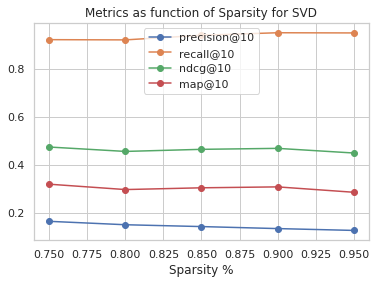

In [26]:
sns.set(style='whitegrid')
plt.plot(spt,r_pres,label="precision@10", marker = "o")
plt.plot(spt,r_recl,label="recall@10", marker = "o")
plt.plot(spt,r_ndcg,label="ndcg@10", marker = "o")
plt.plot(spt,r_maps,label="map@10", marker = "o")


plt.title("Metrics as function of Sparsity for SVD")
plt.xlabel("Sparsity %")
plt.legend()
plt.savefig("../results/metrics_over_sparsity_svd.png")

plt.show()

In [27]:
import json

with open("../results/results_svd.json", "w") as op:
    json.dump(results, op)